In [29]:
# sales_forecasting_example.ipynb

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

In [42]:
# 1. Load raw sales data from ABC store
df = pd.read_csv("../data/Sales Prediction.csv")

# Standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Drop rows where BOTH month and sales are NaN
df = df.dropna(subset=["month", "sales"], how="all").reset_index(drop=True)

# ---------- remove obvious outliers ----------
# 1) remove zero or negative sales
df = df[df["sales"] > 0].copy()

# 2) remove statistical outliers using IQR
q1 = df["sales"].quantile(0.25)
q3 = df["sales"].quantile(0.75)
iqr = q3 - q1

# this factor (1.5) usually catches "the weird spikes" like the ones in your plot
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df["sales"] >= lower_bound) & (df["sales"] <= upper_bound)].copy()


# Overview of the raw data
print(df.head())
print(df.info())

   month      sales
0    1.0  24.321676
1    2.0  29.212176
2    3.0  33.632435
3    4.0  27.904117
4    5.0  31.633817
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   97 non-null     float64
 1   sales   97 non-null     float64
dtypes: float64(2)
memory usage: 2.3 KB
None


In [43]:
# CASE 1: "month" is just a running number (1, 2, 3, ...) and we want to start at 2020-01
start_date = pd.Timestamp("2016-01-01")

# create a proper datetime column based on row position
# if your "month" column is 1-based and strictly increasing, we can do:
df["date"] = [start_date + pd.DateOffset(months=int(m - 1)) for m in df["month"]]

# # now we use "date" as the true time index
df = df.sort_values("date").reset_index(drop=True)

# # Overview of the raw data
print(df.head())
print(df.tail())

   month      sales       date
0    1.0  24.321676 2016-01-01
1    2.0  29.212176 2016-02-01
2    3.0  33.632435 2016-03-01
3    4.0  27.904117 2016-04-01
4    5.0  31.633817 2016-05-01
    month       sales       date
92   96.0  170.254691 2023-12-01
93   97.0  180.410457 2024-01-01
94   98.0  180.751846 2024-02-01
95   99.0  185.935582 2024-03-01
96  100.0  185.827322 2024-04-01


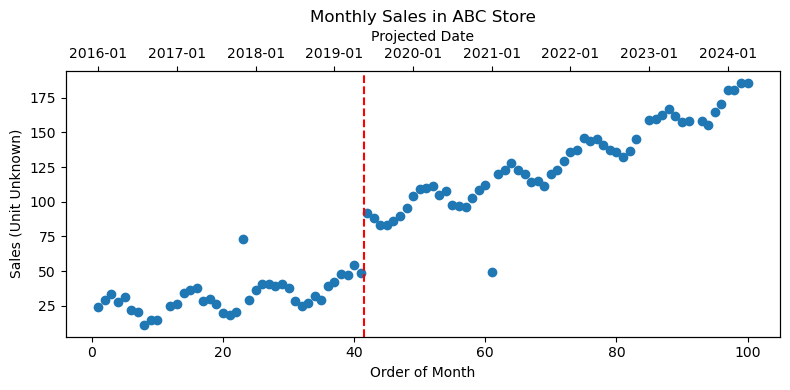

In [44]:
# Quick look at the data
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot sales using the bottom x-axis (month)
ax1.plot(df.month, df.sales, 'o')
ax1.set_xlabel('Order of Month')
ax1.set_ylabel('Sales (Unit Unknown)')
ax1.set_title('Monthly Sales in ABC Store')

# Create a secondary x-axis on top for date
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Show only January dates on the upper x-axis
january_mask = df.date.dt.month == 1
jan_months = df.month[january_mask]
jan_labels = df.date[january_mask].dt.strftime('%Y-%m')

ax2.set_xticks(jan_months)
ax2.set_xticklabels(jan_labels)
ax2.set_xlabel('Projected Date')

ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

plt.tight_layout()
plt.show()

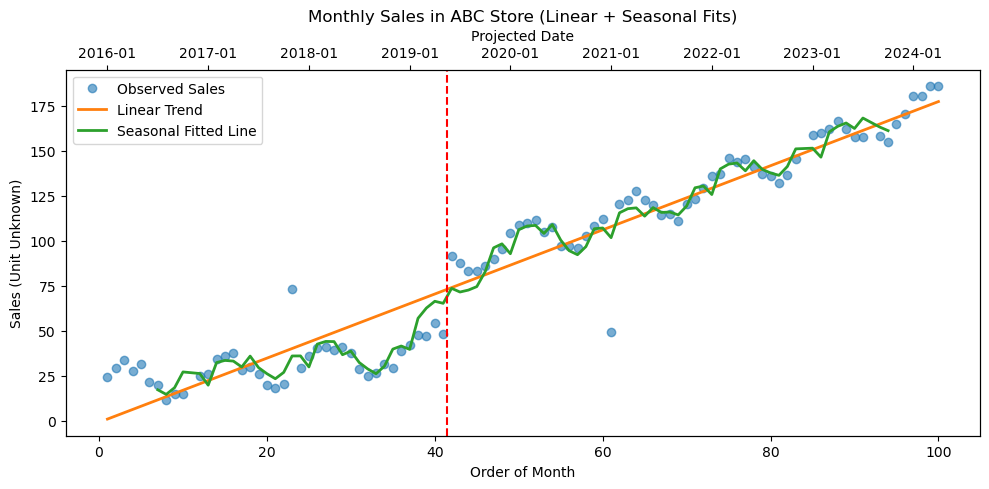

In [50]:
# 2. Linear regression fit
df2 = df.copy()   # ✅ make a copy before modifying

X = df2["month"].values.reshape(-1, 1)
y = df2["sales"].values
linreg = LinearRegression()
linreg.fit(X, y)
df2["trend_linear"] = linreg.predict(X)

# 3. Seasonal decomposition (using statsmodels)
df2 = df2.set_index("date")
result = seasonal_decompose(df2["sales"], model="additive", period=12)
df2["seasonal_fit"] = result.trend + result.seasonal

# 4. Plot data + linear fit + seasonal fit with two x-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bottom x-axis: month (numeric order)
ax1.plot(df2["month"], df2["sales"], "o", label="Observed Sales", alpha=0.6)
ax1.plot(df2["month"], df2["trend_linear"], "-", label="Linear Trend", linewidth=2)
ax1.plot(df2["month"], df2["seasonal_fit"], "-", label="Seasonal Fitted Line", linewidth=2)
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Linear + Seasonal Fits)")

# Top x-axis: only January labels
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

january_mask = df2.index.month == 1
jan_months = df2["month"][january_mask]
jan_labels = df2.index[january_mask].strftime("%Y-%m")

ax2.set_xticks(jan_months)
ax2.set_xticklabels(jan_labels)
ax2.set_xlabel("Projected Date")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()


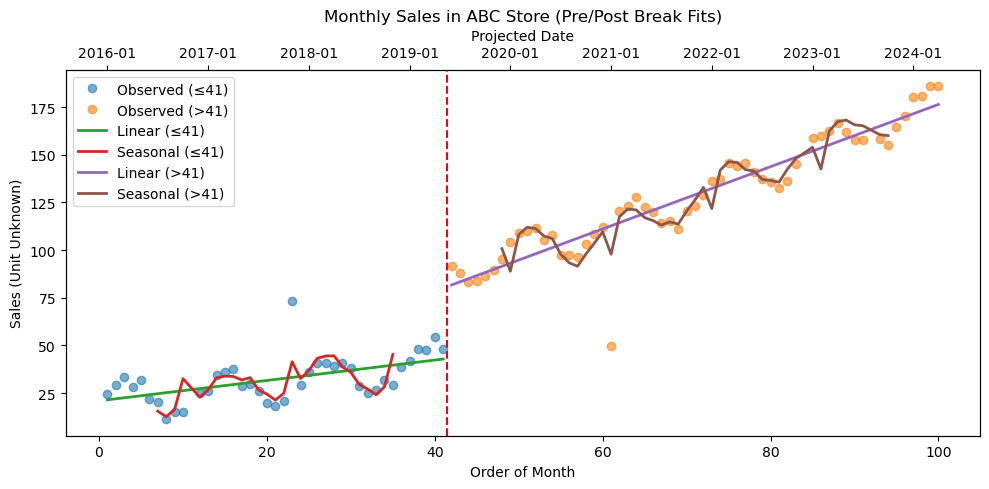

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

# assume df already loaded, cleaned, and has: month, sales, date
# start from your copied version
df2 = df.copy()

# make sure date is indexable later
df2 = df2.sort_values("date").reset_index(drop=True)

# ---------- 1. split into two parts ----------
break_month = 41.5
df2_part1 = df2[df2["month"] <= 41].copy()
df2_part2 = df2[df2["month"] > 41].copy()

# ---------- 2. fit linear + seasonal for part 1 ----------
# linear
X1 = df2_part1["month"].values.reshape(-1, 1)
y1 = df2_part1["sales"].values
lin1 = LinearRegression()
lin1.fit(X1, y1)
df2_part1["trend_linear"] = lin1.predict(X1)

# seasonal: need datetime index
df2_part1_idx = df2_part1.set_index("date")
res1 = seasonal_decompose(df2_part1_idx["sales"], model="additive", period=12)
df2_part1["seasonal_fit"] = (res1.trend + res1.seasonal).values

# ---------- 3. fit linear + seasonal for part 2 ----------
# linear
X2 = df2_part2["month"].values.reshape(-1, 1)
y2 = df2_part2["sales"].values
lin2 = LinearRegression()
lin2.fit(X2, y2)
df2_part2["trend_linear"] = lin2.predict(X2)

# seasonal
df2_part2_idx = df2_part2.set_index("date")
res2 = seasonal_decompose(df2_part2_idx["sales"], model="additive", period=12)
df2_part2["seasonal_fit"] = (res2.trend + res2.seasonal).values

# ---------- 4. plot together with dual x-axes ----------
fig, ax1 = plt.subplots(figsize=(10, 5))

# scatter original points (both parts)
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)

# fitted lines for part 1
ax1.plot(df2_part1["month"], df2_part1["trend_linear"], "-", label="Linear (≤41)", linewidth=2)
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)

# fitted lines for part 2
ax1.plot(df2_part2["month"], df2_part2["trend_linear"], "-", label="Linear (>41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# vertical line to show jump
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Pre/Post Break Fits)")

# ---------- top x-axis with January only ----------
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# we can use the full df2 for January labels
january_mask = df2["date"].dt.month == 1
jan_months = df2["month"][january_mask]
jan_labels = df2["date"][january_mask].dt.strftime("%Y-%m")

ax2.set_xticks(jan_months)
ax2.set_xticklabels(jan_labels)
ax2.set_xlabel("Projected Date")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [55]:
# 3. Target
target_col = "sales"

# 4. Basic time features (use the unified 'date' column)
df["fea_year"] = df["date"].dt.year
df["fea_month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek  # for monthly data this will be similar, but ok to keep

# 5. Lag features
df["lag_1"] = df[target_col].shift(1)
df["lag_2"] = df[target_col].shift(2)
df["lag_7"] = df[target_col].shift(7)  # for monthly data this is a 7-month lag

# 6. Rolling features (use shifted target to avoid lookahead)
df["roll_3"] = df[target_col].shift(1).rolling(window=3).mean()
df["roll_6"] = df[target_col].shift(1).rolling(window=6).mean()

# Drop rows with NaN created by lagging/rolling
df = df.dropna().reset_index(drop=True)

# Quick look
print(df.head())
print(df.tail())

   month      sales       date  fea_year  fea_month  dayofweek      lag_1  \
0   16.0  37.764603 2017-04-01      2017          4          5  36.223946   
1   17.0  28.481158 2017-05-01      2017          5          0  37.764603   
2   18.0  29.703285 2017-06-01      2017          6          3  28.481158   
3   19.0  26.221018 2017-07-01      2017          7          5  29.703285   
4   20.0  20.001199 2017-08-01      2017          8          1  26.221018   

       lag_2      lag_7     roll_3     roll_6  
0  34.321563  11.334801  32.198959  25.231471  
1  36.223946  14.980235  36.103371  29.028865  
2  37.764603  14.990533  34.156569  31.277303  
3  28.481158  24.821180  31.983015  32.090987  
4  29.703285  26.051368  28.135154  32.119262  
    month       sales       date  fea_year  fea_month  dayofweek       lag_1  \
78   96.0  170.254691 2023-12-01      2023         12          4  164.711280   
79   97.0  180.410457 2024-01-01      2024          1          0  170.254691   
80   98.0

In [60]:
# assume df already has: date, month, target_col, and all feature cols built
# 1) keep only data AFTER the jump
df_after = df[df["month"] > 41].copy().reset_index(drop=True)

# if your target column was called "sales", set it here
target_col = "sales"   # adjust if your code used another name

# 2) train/test split only on post-jump data
# if you don't have 24 months after 41, fall back to 20%
test_size = 24 if len(df_after) > 24 else max(1, int(len(df_after) * 0.2))

train_df = df_after.iloc[:-test_size]
test_df = df_after.iloc[-test_size:]

feature_cols = [
    "fea_year",
    "fea_month",
    "dayofweek",
    "lag_1",
    "lag_2",
    "lag_7",
    "roll_3",
    "roll_6",
]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 3) models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}")

# 3.1 Linear Regression (post-jump only)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
evaluate_model("LinearRegression (post-jump)", y_test, y_pred_lr)

# 3.2 Simple Neural Network (optional)
nn = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    random_state=42,
    max_iter=500
)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
evaluate_model("NeuralNetwork (post-jump)", y_test, y_pred_nn)

# 3.3 Optional: Logistic-style bins, still on post-jump
sales_bins = pd.qcut(train_df[target_col], q=3, labels=[0, 1, 2])
log_clf = LogisticRegression(max_iter=500)
log_clf.fit(X_train, sales_bins)
test_bins_pred = log_clf.predict(X_test)
print("LogisticRegression (classification) predicted bins:", np.unique(test_bins_pred))

# 4) Forecast NEXT 24 months, still from post-jump regime
date_col = "date"

last_date = df_after[date_col].max()
future_steps = 24  # months to forecast

future_rows = []
# very important: we extend ONLY the post-jump frame
current_df = df_after.copy()

for i in range(1, future_steps + 1):
    next_date = last_date + pd.DateOffset(months=i)

    row = {}
    row[date_col] = next_date
    row["fea_year"] = next_date.year
    row["fea_month"] = next_date.month
    row["dayofweek"] = next_date.dayofweek

    # lags from CURRENT post-jump history
    row["lag_1"] = current_df[target_col].iloc[-1]
    row["lag_2"] = current_df[target_col].iloc[-2] if len(current_df) >= 2 else current_df[target_col].iloc[-1]
    row["lag_7"] = current_df[target_col].iloc[-7] if len(current_df) >= 7 else current_df[target_col].iloc[0]

    row["roll_3"] = current_df[target_col].iloc[-3:].mean() if len(current_df) >= 3 else current_df[target_col].mean()
    row["roll_6"] = current_df[target_col].iloc[-6:].mean() if len(current_df) >= 6 else current_df[target_col].mean()

    row_df = pd.DataFrame([row])

    # predict with post-jump linear model
    y_fut = lin_reg.predict(row_df[feature_cols])[0]

    # append to current_df so that next lags can see it
    new_row_full = {
        date_col: next_date,
        target_col: y_fut,
        "fea_year": row["fea_year"],
        "fea_month": row["fea_month"],
        "dayofweek": row["dayofweek"],
        "lag_1": row["lag_1"],
        "lag_2": row["lag_2"],
        "lag_7": row["lag_7"],
        "roll_3": row["roll_3"],
        "roll_6": row["roll_6"],
    }
    current_df = pd.concat([current_df, pd.DataFrame([new_row_full])], ignore_index=True)
    future_rows.append({date_col: next_date, target_col: y_fut})

future_df = pd.DataFrame(future_rows)
print("Future prediction (next 24 months, post-jump regime only):")
print(future_df)

LinearRegression (post-jump): MAE=11.91, RMSE=13.50
NeuralNetwork (post-jump): MAE=12.43, RMSE=15.58
LogisticRegression (classification) predicted bins: [2]
Future prediction (next 24 months, post-jump regime only):
         date       sales
0  2024-05-01  165.547836
1  2024-06-01  161.669954
2  2024-07-01  165.828621
3  2024-08-01  165.526080
4  2024-09-01  163.942571
5  2024-10-01  167.315076
6  2024-11-01  165.469505
7  2024-12-01  166.525703
8  2025-01-01  176.183725
9  2025-02-01  175.152890
10 2025-03-01  176.073980
11 2025-04-01  179.572837
12 2025-05-01  179.102184
13 2025-06-01  177.890053
14 2025-07-01  182.559244
15 2025-08-01  180.585761
16 2025-09-01  184.950157
17 2025-10-01  184.005727
18 2025-11-01  182.405611
19 2025-12-01  186.886468
20 2026-01-01  191.380870
21 2026-02-01  189.992465
22 2026-03-01  190.668481
23 2026-04-01  194.073132


/Users/kevinchao/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


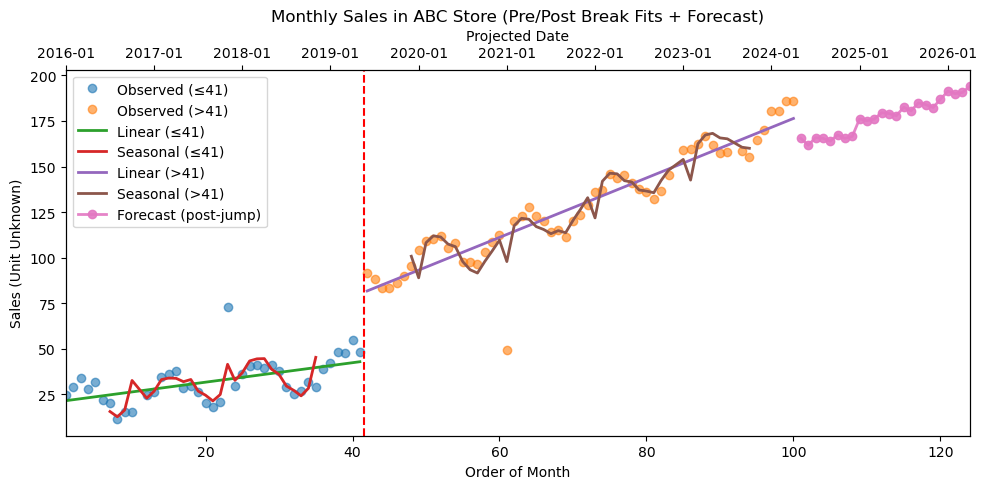

In [62]:
# ---------- 4. plot together with dual x-axes ----------
fig, ax1 = plt.subplots(figsize=(10, 5))

# scatter original points (both parts)
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)

# fitted lines for part 1
ax1.plot(df2_part1["month"], df2_part1["trend_linear"], "-", label="Linear (≤41)", linewidth=2)
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)

# fitted lines for part 2
ax1.plot(df2_part2["month"], df2_part2["trend_linear"], "-", label="Linear (>41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# ---------- add predictive results (future_df) ----------
# future_df is from the post-jump model and has columns: date, sales
# we need to create the month index that continues from the last real month
last_month_num = df2_part2["month"].max()  # e.g. 60
future_df = future_df.copy()
future_df["month"] = np.arange(last_month_num + 1, last_month_num + 1 + len(future_df))

# plot predictions
ax1.plot(
    future_df["month"],
    future_df["sales"],
    "o-",
    label="Forecast (post-jump)",
    linewidth=2,
    alpha=0.9
)

# vertical line to show jump
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Pre/Post Break Fits + Forecast)")

# ---------- top x-axis with January only ----------
ax2 = ax1.twiny()

# extend x-limits to include forecasts
all_min = min(df2_part1["month"].min(), df2_part2["month"].min())
all_max = max(future_df["month"].max(), df2_part2["month"].max())
ax1.set_xlim(all_min, all_max)
ax2.set_xlim(ax1.get_xlim())

# we can use the full df2 for January labels, then append future Januarys
january_mask = df2["date"].dt.month == 1
jan_months = list(df2["month"][january_mask])
jan_labels = list(df2["date"][january_mask].dt.strftime("%Y-%m"))

# add future Januarys if any in future_df
future_jan = future_df[future_df["date"].dt.month == 1]
if not future_jan.empty:
    jan_months.extend(future_jan["month"].tolist())
    jan_labels.extend(future_jan["date"].dt.strftime("%Y-%m").tolist())

ax2.set_xticks(jan_months)
ax2.set_xticklabels(jan_labels)
ax2.set_xlabel("Projected Date")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [61]:
# # 3. Target
# target_col = "sales"

# # 4. Basic time features (use the unified 'date' column)
# df["fea_year"] = df["date"].dt.year
# df["fea_month"] = df["date"].dt.month
# df["dayofweek"] = df["date"].dt.dayofweek  # for monthly data this will be similar, but ok to keep

# # 5. Lag features
# df["lag_1"] = df[target_col].shift(1)
# df["lag_2"] = df[target_col].shift(2)
# df["lag_7"] = df[target_col].shift(7)  # for monthly data this is a 7-month lag

# # 6. Rolling features (use shifted target to avoid lookahead)
# df["roll_3"] = df[target_col].shift(1).rolling(window=3).mean()
# df["roll_6"] = df[target_col].shift(1).rolling(window=6).mean()

# # Drop rows with NaN created by lagging/rolling
# df = df.dropna().reset_index(drop=True)

# # Quick look
# print(df.head())
# print(df.tail())

   month      sales       date  fea_year  fea_month  dayofweek      lag_1  \
0   30.0  37.944143 2018-06-01      2018          6          4  40.811969   
1   31.0  28.709971 2018-07-01      2018          7          6  37.944143   
2   32.0  24.994696 2018-08-01      2018          8          2  28.709971   
3   33.0  26.622915 2018-09-01      2018          9          5  24.994696   
4   34.0  31.845482 2018-10-01      2018         10          0  26.622915   

       lag_2      lag_7     roll_3     roll_6  
0  39.221325  73.117121  40.277100  37.822330  
1  40.811969  29.339621  39.325812  39.256417  
2  37.944143  36.073101  35.822028  38.029229  
3  28.709971  40.689958  30.549604  35.413352  
4  24.994696  40.798005  26.775861  33.050837  
    month       sales       date  fea_year  fea_month  dayofweek       lag_1  \
64   96.0  170.254691 2023-12-01      2023         12          4  164.711280   
65   97.0  180.410457 2024-01-01      2024          1          0  170.254691   
66   98.0

In [8]:
# # 7. Train/test split (last 24 months as test, adjust if your data is shorter)
# test_size = 24 if len(df) > 24 else int(len(df) * 0.2)
# train_df = df.iloc[:-test_size]
# test_df = df.iloc[-test_size:]

# feature_cols = [
#     "fea_year",
#     "fea_month",
#     "dayofweek",
#     "lag_1",
#     "lag_2",
#     "lag_7",
#     "roll_3",
#     "roll_6",
# ]

# X_train = train_df[feature_cols]
# y_train = train_df[target_col]
# X_test = test_df[feature_cols]
# y_test = test_df[target_col]

In [9]:
# # 8. Models
# from sklearn.linear_model import LinearRegression, LogisticRegression
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# def evaluate_model(name, y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = mean_squared_error(y_true, y_pred, squared=False)
#     print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}")

# # 8.1 Linear Regression
# lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train)
# y_pred_lr = lin_reg.predict(X_test)
# evaluate_model("LinearRegression", y_test, y_pred_lr)

# # 8.2 Simple Neural Network
# nn = MLPRegressor(
#     hidden_layer_sizes=(32, 16),
#     random_state=42,
#     max_iter=500
# )
# nn.fit(X_train, y_train)
# y_pred_nn = nn.predict(X_test)
# evaluate_model("NeuralNetwork", y_test, y_pred_nn)

# # 8.3 Optional: Logistic Regression (classification style, not ideal here)
# sales_bins = pd.qcut(train_df[target_col], q=3, labels=[0, 1, 2])
# log_clf = LogisticRegression(max_iter=500)
# log_clf.fit(X_train, sales_bins)
# test_bins_pred = log_clf.predict(X_test)
# print("LogisticRegression (classification) predicted bins:", np.unique(test_bins_pred))


LinearRegression: MAE=16.08, RMSE=34.25
NeuralNetwork: MAE=26.58, RMSE=37.75
LogisticRegression (classification) predicted bins: [2]


/Users/kevinchao/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# # 9. Forecast next 24 months
# date_col = 'date'

# last_date = df[date_col].max()
# future_steps = 24  # 2 years of monthly data

# future_rows = []
# current_df = df.copy()

# for i in range(1, future_steps + 1):
#     next_date = last_date + pd.DateOffset(months=i)

#     row = {}
#     row[date_col] = next_date
#     row["fea_year"] = next_date.year
#     row["fea_month"] = next_date.month
#     row["dayofweek"] = next_date.dayofweek

#     # lags from current_df (which we extend as we go)
#     row["lag_1"] = current_df[target_col].iloc[-1]
#     row["lag_2"] = current_df[target_col].iloc[-2]
#     row["lag_7"] = current_df[target_col].iloc[-7] if len(current_df) >= 7 else current_df[target_col].iloc[0]

#     row["roll_3"] = current_df[target_col].iloc[-3:].mean()
#     row["roll_6"] = current_df[target_col].iloc[-6:].mean() if len(current_df) >= 6 else current_df[target_col].mean()

#     row_df = pd.DataFrame([row])

#     # predict with linear regression
#     y_fut = lin_reg.predict(row_df[feature_cols])[0]

#     # add to current_df for next loop
#     new_row_full = {
#         date_col: next_date,
#         target_col: y_fut,
#         "fea_year": row["fea_year"],
#         "fea_month": row["fea_month"],
#         "dayofweek": row["dayofweek"],
#         "lag_1": row["lag_1"],
#         "lag_2": row["lag_2"],
#         "lag_7": row["lag_7"],
#         "roll_3": row["roll_3"],
#         "roll_6": row["roll_6"],
#     }
#     current_df = pd.concat([current_df, pd.DataFrame([new_row_full])], ignore_index=True)
#     future_rows.append({date_col: next_date, target_col: y_fut})

# future_df = pd.DataFrame(future_rows)
# print("Future prediction (next 24 months):")
# print(future_df)

Future prediction (next 24 months):
         date       sales
0  2024-05-01  185.932128
1  2024-06-01  188.351863
2  2024-07-01  196.325363
3  2024-08-01  198.560752
4  2024-09-01  200.388422
5  2024-10-01  209.669017
6  2024-11-01  209.023506
7  2024-12-01  210.124041
8  2025-01-01  214.581750
9  2025-02-01  213.932123
10 2025-03-01  215.983294
11 2025-04-01  222.391114
12 2025-05-01  223.031395
13 2025-06-01  222.623102
14 2025-07-01  229.578326
15 2025-08-01  229.483644
16 2025-09-01  236.484060
17 2025-10-01  238.037912
18 2025-11-01  237.427908
19 2025-12-01  244.587950
20 2026-01-01  243.239144
21 2026-02-01  241.784064
22 2026-03-01  242.984679
23 2026-04-01  248.153224


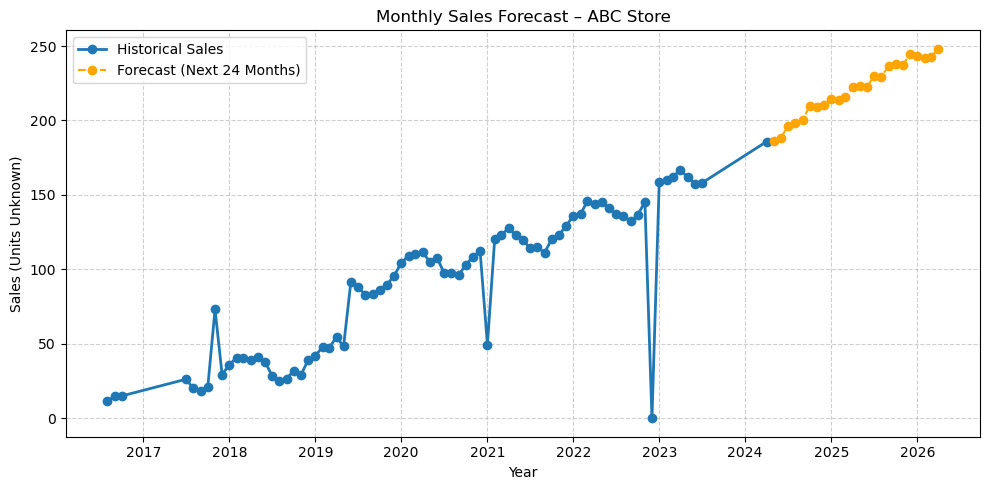

In [11]:
# import matplotlib.pyplot as plt

# # Combine historical and forecast data
# df_plot = pd.concat([df[["date", "sales"]], future_df], ignore_index=True)

# # Create the plot
# plt.figure(figsize=(10, 5))
# plt.plot(df["date"], df["sales"], 'o-', label="Historical Sales", linewidth=2)
# plt.plot(future_df["date"], future_df["sales"], 'o--', label="Forecast (Next 24 Months)", color="orange")

# plt.title("Monthly Sales Forecast – ABC Store")
# plt.xlabel("Year")
# plt.ylabel("Sales (Units Unknown)")
# plt.legend()
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.tight_layout()
# plt.show()
